# Look into missing values in BL surveys

In [1]:
# Set up
import pandas as pd
import numpy as np
import sys
from pathlib import Path
CODE_ROOT = Path.cwd().parents[1]
sys.path.append(str(CODE_ROOT))
import config
from openpyxl import load_workbook
from openpyxl.formatting.rule import FormulaRule
from openpyxl.styles import Font, PatternFill
from openpyxl.utils import range_boundaries
import os
import shutil
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

In [2]:
# Load data
labs = pd.read_csv(config.BL_RAW_SAMPLE / "final_sample_with_BL_file_status.csv")

# BL surveys folder
bl_surveys_folder = config.BL_RAW_SURVEY / "1_LabExcels"

## Firstly, check how many labs have completed each sheet

In [3]:
# Sheets to check and their ranges
sheet_mappings = {
    "fumecupboards": {"orig_sheet": "2. Fume Cupboards", "dest_sheet": "Fume Cupboards", "range": "C6:L17"},
    "fridges": {"orig_sheet": "3. Fridges (4°C)", "dest_sheet": "Fridges (4°C)", "range": "C6:L9"},
    "freezers": {"orig_sheet": "4. Freezers (-20°C)", "dest_sheet": "Freezers (-20°C)", "range": "C6:V13"},
    "ults": {"orig_sheet": "5. ULT Freezers", "dest_sheet": "ULT Freezers", "range": "C6:L14"},
    "glassware": {"orig_sheet": "6. Glassware Drying Cabinets", "dest_sheet": "Glassware Drying Cabinets", "range": "C6:L15"},
    "microbio": {"orig_sheet": "7. Microbio Safety Cabinets", "dest_sheet": "Microbio Safety Cabinets", "range": "C6:L14"},
    "cryostats": {"orig_sheet": "8. Cryostats", "dest_sheet": "Cryostats", "range": "C6:L13"},
    "baths": {"orig_sheet": "9. Water Baths", "dest_sheet": "Water Baths", "range": "C6:L16"},
    "incubators": {"orig_sheet": "10. CO2 Incubators", "dest_sheet": "CO2 Incubators", "range": "C6:L11"},
    "heaters": {"orig_sheet": "11. Block Heaters", "dest_sheet": "Block Heaters", "range": "C6:L14"},
    "it": {"orig_sheet": "12. IT Equipment", "dest_sheet": "IT Equipment", "range": "C6:L14"},
}

In [4]:
# Function to check whether each sheet contains any data
def has_data(ws, cell_range):
    min_col, min_row, max_col, max_row = range_boundaries(cell_range)
    for row in ws.iter_rows(min_row=min_row, max_row=max_row, min_col=min_col, max_col=max_col, values_only=True):
        if any(cell is not None and str(cell).strip() != "" for cell in row):
            return True
    return False

In [5]:
# For each labgroupid where survey filled, check each sheet of the BL survey
labs_to_check = labs[(labs["file_filled"] == True)]

records = []

for labgroupid, group in labs_to_check.groupby("labgroupid"):

    # Get enumerator info from current group
    enum_id = group["enum_id"].iloc[0]
    name = group["foldername"].iloc[0]
    treatment_status = group["Treatment Status"].iloc[0]

    filename = config.BL_RAW_SURVEY / "1_LabExcels" / f"BL_{labgroupid}.xlsx"
    wb = load_workbook(filename, data_only=True, read_only=True)

    row_result = {"labgroupid": labgroupid}
    row_result["foldername"] = name
    row_result["Treatment Status"] = treatment_status
    for key, info in sheet_mappings.items():
        ws = wb[info["orig_sheet"]]
        row_result[key] = has_data(ws, info["range"])
    
    records.append(row_result)

# Convert to dataframe
checked_surveys = pd.DataFrame(records)

In [6]:
# Check how many are missing all sheets (probably an enumerator error)
equipment_cols = checked_surveys.columns.drop(["labgroupid", "foldername", "Treatment Status"])
all_sheets_missing_mask = ~checked_surveys[equipment_cols].any(axis=1)
missing_all_sheets = checked_surveys.loc[all_sheets_missing_mask, "labgroupid"]
print("Labgroup IDs with all sheets missing:")
print(missing_all_sheets.tolist())

Labgroup IDs with all sheets missing:
[133]


In [7]:
# Check how many labs only have IT equipment filled
other_equipment_cols = checked_surveys.columns.drop(["labgroupid", "foldername", "Treatment Status", "it"])
it_only_mask = (checked_surveys["it"] == True) & (~checked_surveys[other_equipment_cols].any(axis=1))
it_only_labs = checked_surveys.loc[it_only_mask, "labgroupid"]
print("No. lab groups with only IT equipment filled:")
print(len(it_only_labs.tolist()))

No. lab groups with only IT equipment filled:
46


In [8]:
# Check how many labs have fume cupboards filled
fume_cupboard_mask = (checked_surveys["fumecupboards"] == True)
fume_cupboard_labs = checked_surveys.loc[fume_cupboard_mask, "labgroupid"]
print("No. lab groups with fume cupboards filled:")
print(len(fume_cupboard_labs.tolist()))

# Check how many labs have fume cupboards filled and are treatment labs
fume_cupboard_treated_mask = (checked_surveys["fumecupboards"] == True) & (checked_surveys["Treatment Status"] == "treatment")
fume_cupboard_treated_labs = checked_surveys.loc[fume_cupboard_treated_mask, "labgroupid"]
print("No. treated lab groups with fume cupboards filled:")
print(len(fume_cupboard_treated_labs.tolist()))

No. lab groups with fume cupboards filled:
61
No. treated lab groups with fume cupboards filled:
32


In [9]:
# Check how many labs have IT equipment filled
it_mask = (checked_surveys["it"] == True)
it_labs = checked_surveys.loc[it_mask, "labgroupid"]
print("No. lab groups with IT equipment filled:")
print(len(it_labs.tolist()))

No. lab groups with IT equipment filled:
126


In [10]:
# Summarize number of labs with data per equipment type
total_summary = checked_surveys[equipment_cols].sum().rename("num_labs_with_data")

treated_checked_surveys = checked_surveys[checked_surveys["Treatment Status"] == "treatment"]
treated_summary = treated_checked_surveys[equipment_cols].sum().rename("num_treated_labs_with_data")

summary_df = pd.concat([total_summary, treated_summary], axis=1).reset_index()
summary_df.rename(columns={"index": "equipment"}, inplace=True)

print(summary_df)

        equipment  num_labs_with_data  num_treated_labs_with_data
0   fumecupboards                  61                          32
1         fridges                  78                          39
2        freezers                  67                          35
3            ults                  52                          29
4       glassware                  24                          14
5        microbio                  36                          21
6       cryostats                  17                          10
7           baths                  54                          30
8      incubators                  30                          19
9         heaters                  51                          28
10             it                 126                          63


In [11]:
# Prepare data for plotting

# Equipment names (x-axis)
equipment = summary_df["equipment"]

# Values for plotting
all_labs = summary_df["num_labs_with_data"]
treated_labs = summary_df["num_treated_labs_with_data"]

# Bar positions
x = np.arange(len(equipment))  # the label locations
width = 0.35  # width of the bars

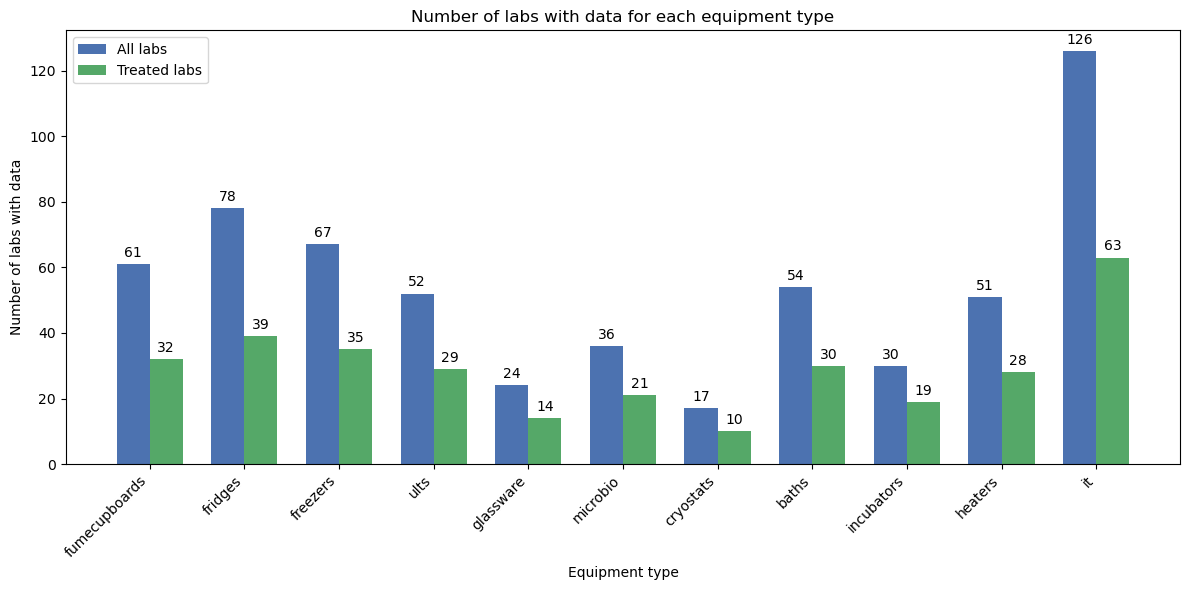

In [12]:
# Plot summary
fig, ax = plt.subplots(figsize=(12, 6))

# Bars for all labs
bars1 = ax.bar(x - width/2, all_labs, width, label='All labs', color='#4C72B0')

# Bars for treated labs
bars2 = ax.bar(x + width/2, treated_labs, width, label='Treated labs', color='#55A868')

# Labels, title, and legend
ax.set_ylabel('Number of labs with data')
ax.set_xlabel('Equipment type')
ax.set_title('Number of labs with data for each equipment type')
ax.set_xticks(x)
ax.set_xticklabels(equipment, rotation=45, ha='right')
ax.legend()

# Add counts on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [15]:
# For fume cupboards, check how many treated labs do not have data in the expected columns

fumecupboards_records = []

for labgroupid in fume_cupboard_treated_labs:
    filename = config.BL_RAW_SURVEY / "1_LabExcels" / f"BL_{labgroupid}.xlsx"
    wb = load_workbook(filename, data_only=True, read_only=True)

    ws = wb["2. Fume Cupboards"]

    row_result = {"labgroupid": labgroupid}

    # Type 1: check column C
    row_result["Type 1"] = has_data(ws, "C6:C17")

    # Extract the cell values for Type 1
    row_result["type1_controller_type"] = ws["C6"].value
    row_result["type1_controller_type_co"] = ws["D6"].value
    row_result["type1_sash_width_mc"] = ws["C7"].value
    row_result["type1_sash_width_mc_co"] = ws["D7"].value
    row_result["type1_sash_width_fc"] = ws["C8"].value
    row_result["type1_sash_width_fc_co"] = ws["D8"].value
    row_result["type1_face_velocity_mc"] = ws["C9"].value
    row_result["type1_face_velocity_mc_co"] = ws["D9"].value
    row_result["type1_face_velocity_fc"] = ws["C10"].value
    row_result["type1_face_velocity_fc_co"] = ws["D10"].value
    row_result["type1_no"] = ws["C11"].value
    row_result["type1_no_co"] = ws["D11"].value
    row_result["type1_lifted"] = ws["C12"].value
    row_result["type1_lifted_co"] = ws["D12"].value
    row_result["type1_hours"] = ws["C13"].value
    row_result["type1_hours_co"] = ws["D13"].value
    row_result["type1_days_mc"] = ws["C14"].value
    row_result["type1_days_mc_co"] = ws["D14"].value
    row_result["type1_days_fc"] = ws["C15"].value
    row_result["type1_days_fc_co"] = ws["D15"].value
    row_result["type1_surface"] = ws["C16"].value
    row_result["type1_surface_co"] = ws["D16"].value

    fumecupboards_records.append(row_result)
    
# Convert to dataframe
fumecupboards_data = pd.DataFrame(fumecupboards_records)
fumecupboards_data.to_csv(config.DATA_ROOT / "13_Calculators" / "3_Reports" / "fumecupboards_treated_labs.csv", index=False)
